In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from VMOSfunc import *
from scipy.stats import chisquare

In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>5100*k) & (wo_wave<5130*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [3]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 100
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

In [4]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/VIMOS"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='black',label='data',drawstyle='steps-mid',lw = 3)
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)",fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_data.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='--',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_BLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(wo_wave[select],fit,'r:',label='fit')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(wo_wave[select],residual/error[select],drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_residual.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)


In [5]:
def central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/VIMOS"):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    popt = np.append(popt_full_fit,central_coordinates)
    central_cordinates_err = [0,0]
    err = np.append(parameters_err,central_cordinates_err)
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'central_x':18,'central_y':19}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)



In [6]:
def algorithm_script(obj,p_init,z,broad2,prefix_path_cube="/home/mainak/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/mainak/Downloads/Outflow_paper1/VIMOS"):
    print ('%s'%(obj)) 
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/VIMOS_O3Ha/%s/%s_blue.rscube.fits'%(prefix_path_cube,obj,obj))  
    (orange_cube,orange_err,orange_wave,orange_header) = loadCube('%s/VIMOS_O3Ha/%s/%s_blue.rscube.fits'%(prefix_path_cube,obj,obj))  

    [brightest_pixel_x,brightest_pixel_y] = brightest_pixel(wo_cube)
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    print (factor)
    error = factor*error
    
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2) 
    print (popt_full_fit,parameters_err)  
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)

HE1310-1051
1.1811879830918275
[ 5.10756961e-01  8.33620208e+00  1.03157894e+04  1.04888430e+02
  4.34581287e-01  2.29449144e+00  1.02930672e+04  2.19085257e+02
  1.18173716e+00  1.42124705e-01  1.04303638e+04  1.56095739e+03
  0.00000000e+00  0.00000000e+00  1.02810000e+04  1.50000000e+03
 -4.14013659e-01  3.08658426e+00] [2.21369627e-02 1.08675616e-01 2.52169347e-01 1.00713068e+00
 1.78050771e-02 1.18680027e-01 1.53668519e+00 3.35212457e+00
 3.33613340e-03 1.75305156e-03 3.15499849e+00 4.03445839e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.32052836e-03 2.70544936e-02]


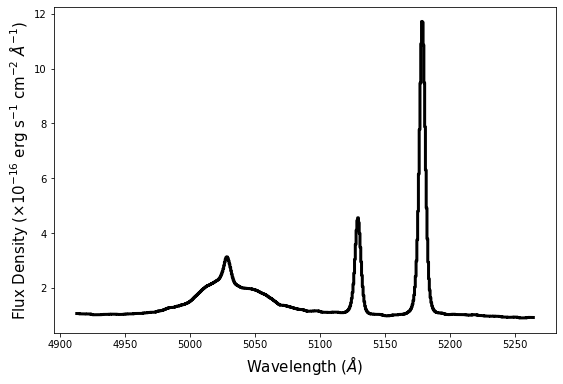

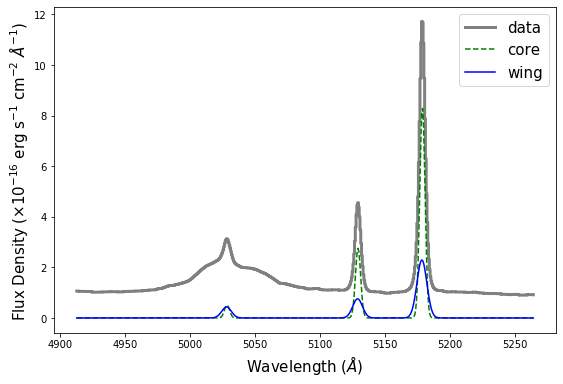

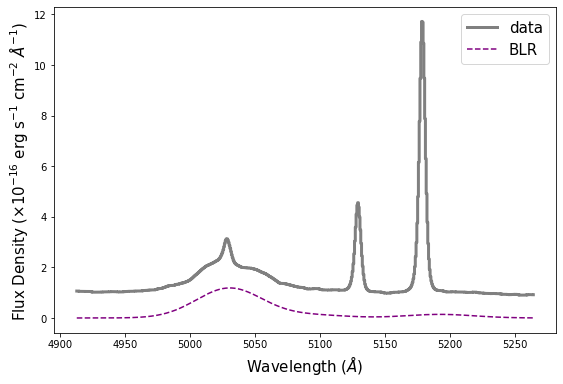

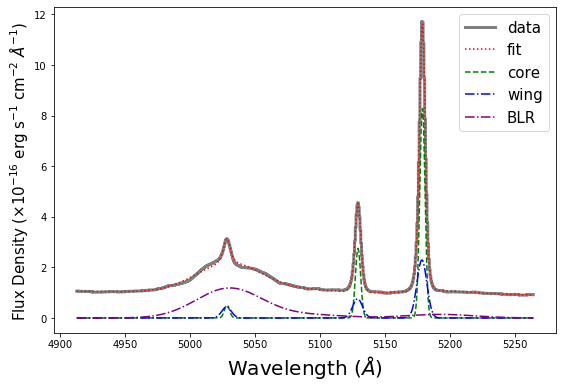

No handles with labels found to put in legend.


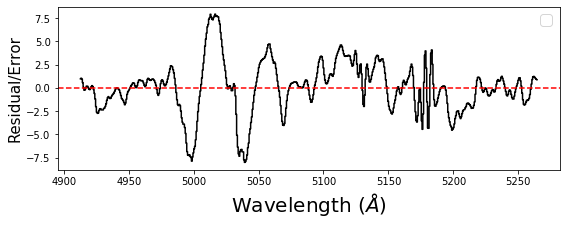

In [7]:
z = {"HE1310-1051":0.03427}

objs = z.keys()

broad2= {'HE1310-1051':False}

p_init= {'HE1310-1051':[1.139,1.5,10281.0,100.0,0.0,0.0,10281.0,200.0,1.0,1.0,10281.0,1000.0,0.0,0.0,10281.0,1500.0,-0.001,2.0]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


HE1338-1423
1.042494
[ 1.06654086e+00  1.16403742e+01  1.23955285e+04  1.18446628e+02
  7.15931893e-01  4.06887097e+00  1.24197466e+04  2.90074930e+02
  3.95890956e+00  3.71315393e-01  1.24578886e+04  5.95415220e+02
  2.55648263e+00  4.66583359e-01  1.25756104e+04  1.47463858e+03
 -1.06407262e+00  8.27125571e+00] [3.06082222e-02 5.83414821e-02 2.01084922e-01 5.44752746e-01
 4.95085616e-02 6.21320444e-02 7.87734712e-01 1.78854911e+00
 2.75665662e-02 5.17926893e-03 1.06815126e+00 4.02318718e+00
 2.21027563e-02 5.01860697e-03 2.67149418e+00 5.72991508e+00
 8.06572254e-03 4.10915892e-02]


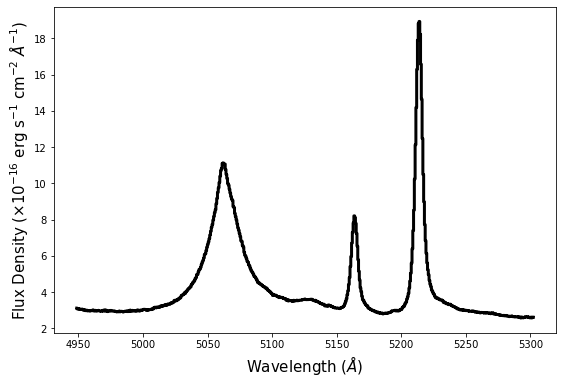

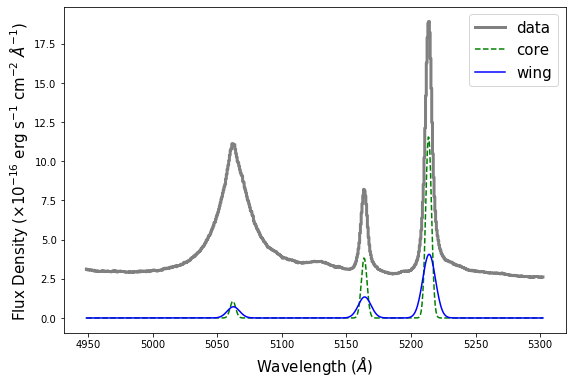

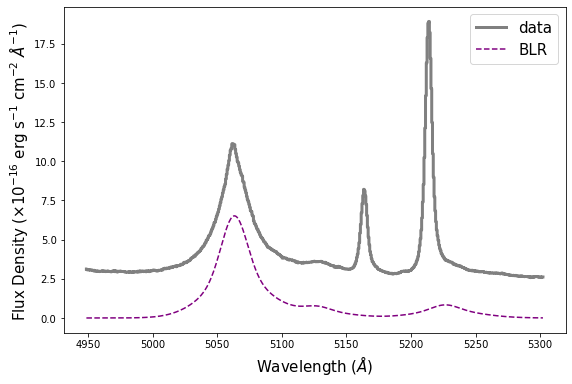

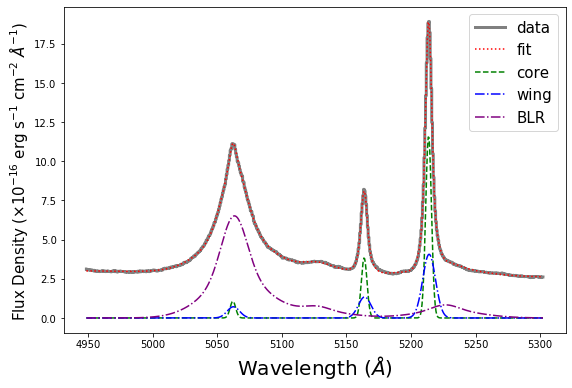

No handles with labels found to put in legend.


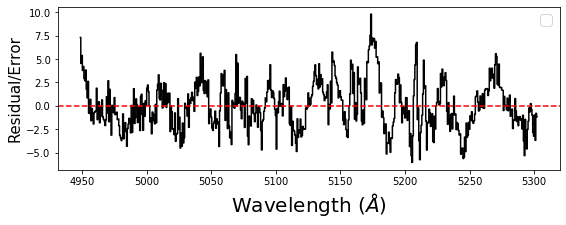

In [8]:
z = {"HE1338-1423":0.04179}

objs = z.keys()

broad2= {'HE1338-1423':True}

p_init= {'HE1338-1423':[10,15,12390.0,120.0,2,1,12400.0,300.0,5.0,1.0,12537.0,500.0,0.5,0.5,12537.0,1000.0,-0.001,2.0]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 